### Twitter Sentiment Analysis

In [287]:
#Importing required libraries
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from wordcloud import WordCloud
import gensim
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, ShuffleSplit
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import RandomizedSearchCV
import pickle 
import warnings 
warnings.filterwarnings("ignore")

In [95]:
#Loading the dataset
data = pd.read_csv('train.csv')

In [96]:
#Understanding the dataset
data.head()

,text,sentiment
0,"oh Marly, I`m so sorry!! I hope you find her...",neutral
1,Playing Ghost Online is really interesting. Th...,positive
2,is cleaning the house for her family who is co...,neutral
3,gotta restart my computer .. I thought Win7 wa...,neutral
4,SEe waT I Mean bOuT FoLL0w fRiiDaYs... It`S cA...,neutral


In [97]:
data.tail()

,text,sentiment
27443,LIKE DREW SAID 'GIVE TC A CHANCE' WE WILL MIS...,negative
27444,rec game....trying not to cry...the pain is to...,negative
27445,Sure. I`ll try n keep that up! =P You enjoy s...,positive
27446,Naw.. it was pretty tame. Only 1 guy in costu...,neutral
27447,morning twit-friends! welcome to my new followers,positive


In [98]:
data.shape

(27448, 2)

In [110]:
#Checking for null values
data.isnull().sum()

text         1
sentiment    0
dtype: int64

In [111]:
#Dropping row containing null value
data.dropna(inplace=True)
data = data.reset_index(drop=True)

In [112]:
#Checking for imbalance in the dataset
data['sentiment'].value_counts()

neutral     11105
positive     8575
negative     7767
Name: sentiment, dtype: int64

The dataset looks seemingly balanced. 

In [113]:
#Preprocessing the data
df = copy.deepcopy(data)
df['text'] = df['text'].str.lower()
df['text'].replace(regex=True, inplace=True, to_replace=r'@[a-z0-9_.]+', value=r'') #removes twitter user handles
df['text'].replace(regex=True, inplace=True, to_replace=r'\w+.\/\/\S+', value=r'') #removes url
df['text'].replace(regex=True, inplace=True, to_replace=r'[^a-z|A-Z|^\s]', value=r'') #removes non-alphabetical characters 

Preprocessing involved removal of twitter handles, hashtags, special characters, numbers and punctuations. This was done with the help of _regex_.

In [169]:
#Label encoding the target feature
df['sentiment'] = df['sentiment'].replace(['negative', 'positive', 'neutral'], [0, 1, 2])
df['sentiment'] = df['sentiment'].astype('category')

In [101]:
#Text Normalization
porter = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [102]:
#Function for performing STEMMING on a sentence
def sentStem(sentence):
    token_words = word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        if word not in stop_words:
            stem_sentence.append(porter.stem(word))
            stem_sentence.append(" ")
    return "".join(stem_sentence)

#Function for performing LEMMATIZATION on a sentence
def sentLemma(sentence):
    token_words = word_tokenize(sentence)
    lemma_sentence=[]
    for word in token_words:
        if word not in stop_words:
            lemma_sentence.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
            lemma_sentence.append(" ")
    return "".join(lemma_sentence)

In [117]:
textStem = [sentStem(x) for x in df['text']]
textLemma = [sentLemma(x) for x in df['text']]

Texts were normalised using Stemming and Lemmatization. Stop words corpus was used to remove repetitive stop words from the dataset.

#### Data Visualization using Word Cloud

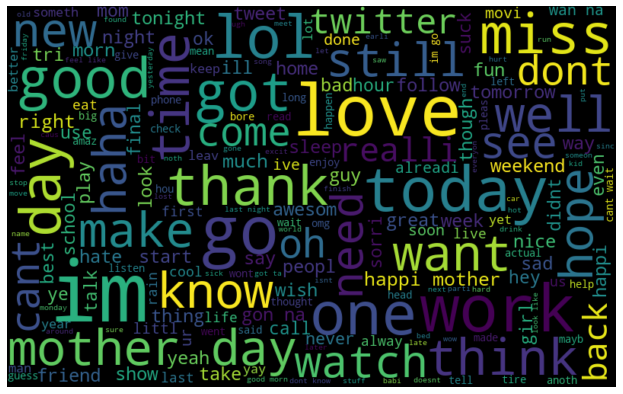

In [130]:
#Stemming word cloud: all words
all_words = ' '.join([text for text in textStem])
cloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(12, 7))
plt.imshow(cloud, interpolation="bilinear")
plt.axis('off')
plt.show()

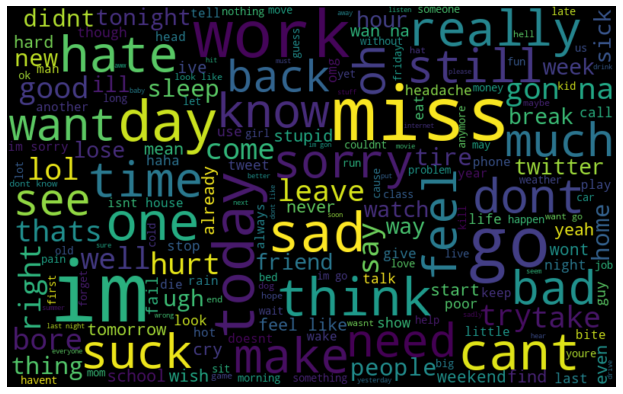

In [219]:
#Lemmatization word cloud: negative words
a = [df['text'][df['sentiment']==0].index.values]
negative = [textLemma[a[0][i]] for i in range(len(a[0]))]
all_words = ' '.join([text for text in negative])
cloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)

plt.figure(figsize=(12, 7))
plt.imshow(cloud, interpolation="bilinear")
plt.axis('off')
plt.show()

In [221]:
#Updating dataset with new analysed text
df['StemText'] = pd.Series(textStem)
df['LemmaText'] = pd.Series(textLemma)

In [289]:
#Implementing word2vec model
tweet = df['LemmaText'].apply(lambda x: x.split())
model_w2v = gensim.models.Word2Vec(tweet, size=200, window=5, min_count=2, sg = 1, #1 for skip-gram model
                    hs = 0, negative = 10, workers= 2)
model_w2v.train(tweet, total_examples = len(df['LemmaText']), epochs=20)

(3235264, 3952200)

Word2Vec model was implemented to observe the words similarities and respective weights.

In [291]:
#Finding words similar to 'good'
model_w2v.wv.most_similar(positive="good")

[('goooood', 0.5706089735031128),
 ('oll', 0.5623209476470947),
 ('gents', 0.5568684339523315),
 ('goooooood', 0.5508071780204773),
 ('guten', 0.5433383584022522),
 ('kelley', 0.5406585335731506),
 ('crow', 0.5387566089630127),
 ('twiggas', 0.5361169576644897),
 ('scones', 0.5354639887809753),
 ('animation', 0.5326860547065735)]

In [294]:
#Finding words similar to 'hate'
model_w2v.wv.most_similar(positive="hate")

[('himi', 0.509508490562439),
 ('carson', 0.47082212567329407),
 ('element', 0.46322861313819885),
 ('hairdresser', 0.4625343084335327),
 ('rash', 0.4580879211425781),
 ('disposable', 0.45736825466156006),
 ('gahh', 0.4447898864746094),
 ('beside', 0.4430497884750366),
 ('colds', 0.4361380636692047),
 ('gumbo', 0.4359077513217926)]

#### **Predictive Models: Sentiment Prediction**

In [253]:
#Predictive modelling

#Splitting the dataset
xtrain_l, xtest_l, ytrain_l, ytest_l = train_test_split(df['LemmaText'], df['sentiment'], 
                                                     test_size=0.30, random_state=42) #using lemmatized data

In [277]:
#SGD classifier
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
print ("Model: STOCHASTIC GRADIENT DESCENT")

text_clf = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, 
                            random_state=42, max_iter=5, tol=None))])

scores = cross_val_score(text_clf, xtrain_l, ytrain_l, cv=cv)
print ("\nCross Validation Scores on the training set: ", scores)


modelSGD = text_clf.fit(xtrain_l, ytrain_l)
prediction = modelSGD.predict(xtest_l)
print("accuracy: {}%".format(round(accuracy_score(ytest_l, prediction)*100, 2)))
print("\nCONFUSION MATRIX: \n\n", confusion_matrix(ytest_l, prediction))
print("\nCLASSIFICATION REPORT: \n\n", classification_report(ytest_l, prediction))

Model: STOCHASTIC GRADIENT DESCENT

Cross Validation Scores on the training set:  [0.66437643 0.68290652 0.67645222 0.67915886 0.68061628]
accuracy: 68.62%

CONFUSION MATRIX: 

 [[1245  157  875]
 [  98 1895  624]
 [ 328  502 2511]]

CLASSIFICATION REPORT: 

               precision    recall  f1-score   support

           0       0.75      0.55      0.63      2277
           1       0.74      0.72      0.73      2617
           2       0.63      0.75      0.68      3341

    accuracy                           0.69      8235
   macro avg       0.70      0.67      0.68      8235
weighted avg       0.70      0.69      0.68      8235



In [275]:
#Random Forest classifier
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
print ("Model: RANDOM FOREST")

text_clf = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier())])

scores = cross_val_score(text_clf, xtrain_l, ytrain_l, cv=cv)
print ("\nCross Validation Scores on the training set: ", scores)


modelRF = text_clf.fit(xtrain_l, ytrain_l)
prediction = modelRF.predict(xtest_l)
print("accuracy: {}%".format(round(accuracy_score(ytest_l, prediction)*100, 2)))
print("\nCONFUSION MATRIX: \n\n", confusion_matrix(ytest_l, prediction))
print("\nCLASSIFICATION REPORT: \n\n", classification_report(ytest_l, prediction))

Model: RANDOM FOREST

Cross Validation Scores on the training set:  [0.68561316 0.69165105 0.69290027 0.68707058 0.69560691]
accuracy: 70.5%

CONFUSION MATRIX: 

 [[1400  142  735]
 [ 115 1935  567]
 [ 379  491 2471]]

CLASSIFICATION REPORT: 

               precision    recall  f1-score   support

           0       0.74      0.61      0.67      2277
           1       0.75      0.74      0.75      2617
           2       0.65      0.74      0.69      3341

    accuracy                           0.71      8235
   macro avg       0.72      0.70      0.70      8235
weighted avg       0.71      0.71      0.70      8235



In [276]:
#SVM classifier
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=0)
print ("Model: SUPPORT VECTOR MACHINES")

text_clf = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LinearSVC(multi_class='ovr'))])

scores = cross_val_score(text_clf, xtrain_l, ytrain_l, cv=cv)
print ("\nCross Validation Scores on the training set: ", scores)


modelSVM = text_clf.fit(xtrain_l, ytrain_l)
prediction = modelSVM.predict(xtest_l)
print("accuracy: {}%".format(round(accuracy_score(ytest_l, prediction)*100, 2)))
print("\nCONFUSION MATRIX: \n\n", confusion_matrix(ytest_l, prediction))
print("\nCLASSIFICATION REPORT: \n\n", classification_report(ytest_l, prediction))

Model: SUPPORT VECTOR MACHINES

Cross Validation Scores on the training set:  [0.65542369 0.66791589 0.6622944  0.65875494 0.66333542]
accuracy: 67.21%

CONFUSION MATRIX: 

 [[1444  149  684]
 [ 155 1890  572]
 [ 582  558 2201]]

CLASSIFICATION REPORT: 

               precision    recall  f1-score   support

           0       0.66      0.63      0.65      2277
           1       0.73      0.72      0.72      2617
           2       0.64      0.66      0.65      3341

    accuracy                           0.67      8235
   macro avg       0.68      0.67      0.67      8235
weighted avg       0.67      0.67      0.67      8235



|Model|Accuracy|
|-----|--------|
|SGD Classifier|68.62%|
|Random Forest|70.5%|
|SVM|67.21%|

In [288]:
#Saving the predictive models
sgd_model = pickle.dumps(modelSGD) 
rf_model = pickle.dumps(modelRF) 
svm_model = pickle.dumps(modelSVM) 

In [296]:
#Save the best predictive model(Random Forest) to disk
filename = 'finalized_model.pkl'
pickle.dump(modelRF, open(filename, 'wb'))

Reload finalized_model.pkl file to use for predictions on testset data